In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np 
# import pandas as pd 
import matplotlib.pyplot as plt
# import geopandas as gpd
import sklearn, sklearn.cross_decomposition
from sklearn.cross_decomposition import CCA
sys.path.append('../src/')
sys.path.append('../content/')
import data_utils as du
import loadpaths
path_dict_pecl = loadpaths.loadpaths()
import analysis_utils as au

Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
Counter({1: 8610, 0: 6882, 7: 417, 6: 382, 2: 87, 8: 5, 5: 1})


/opt/anaconda3/envs/pecl/lib/python3.10/site-packages/matplotlib/cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


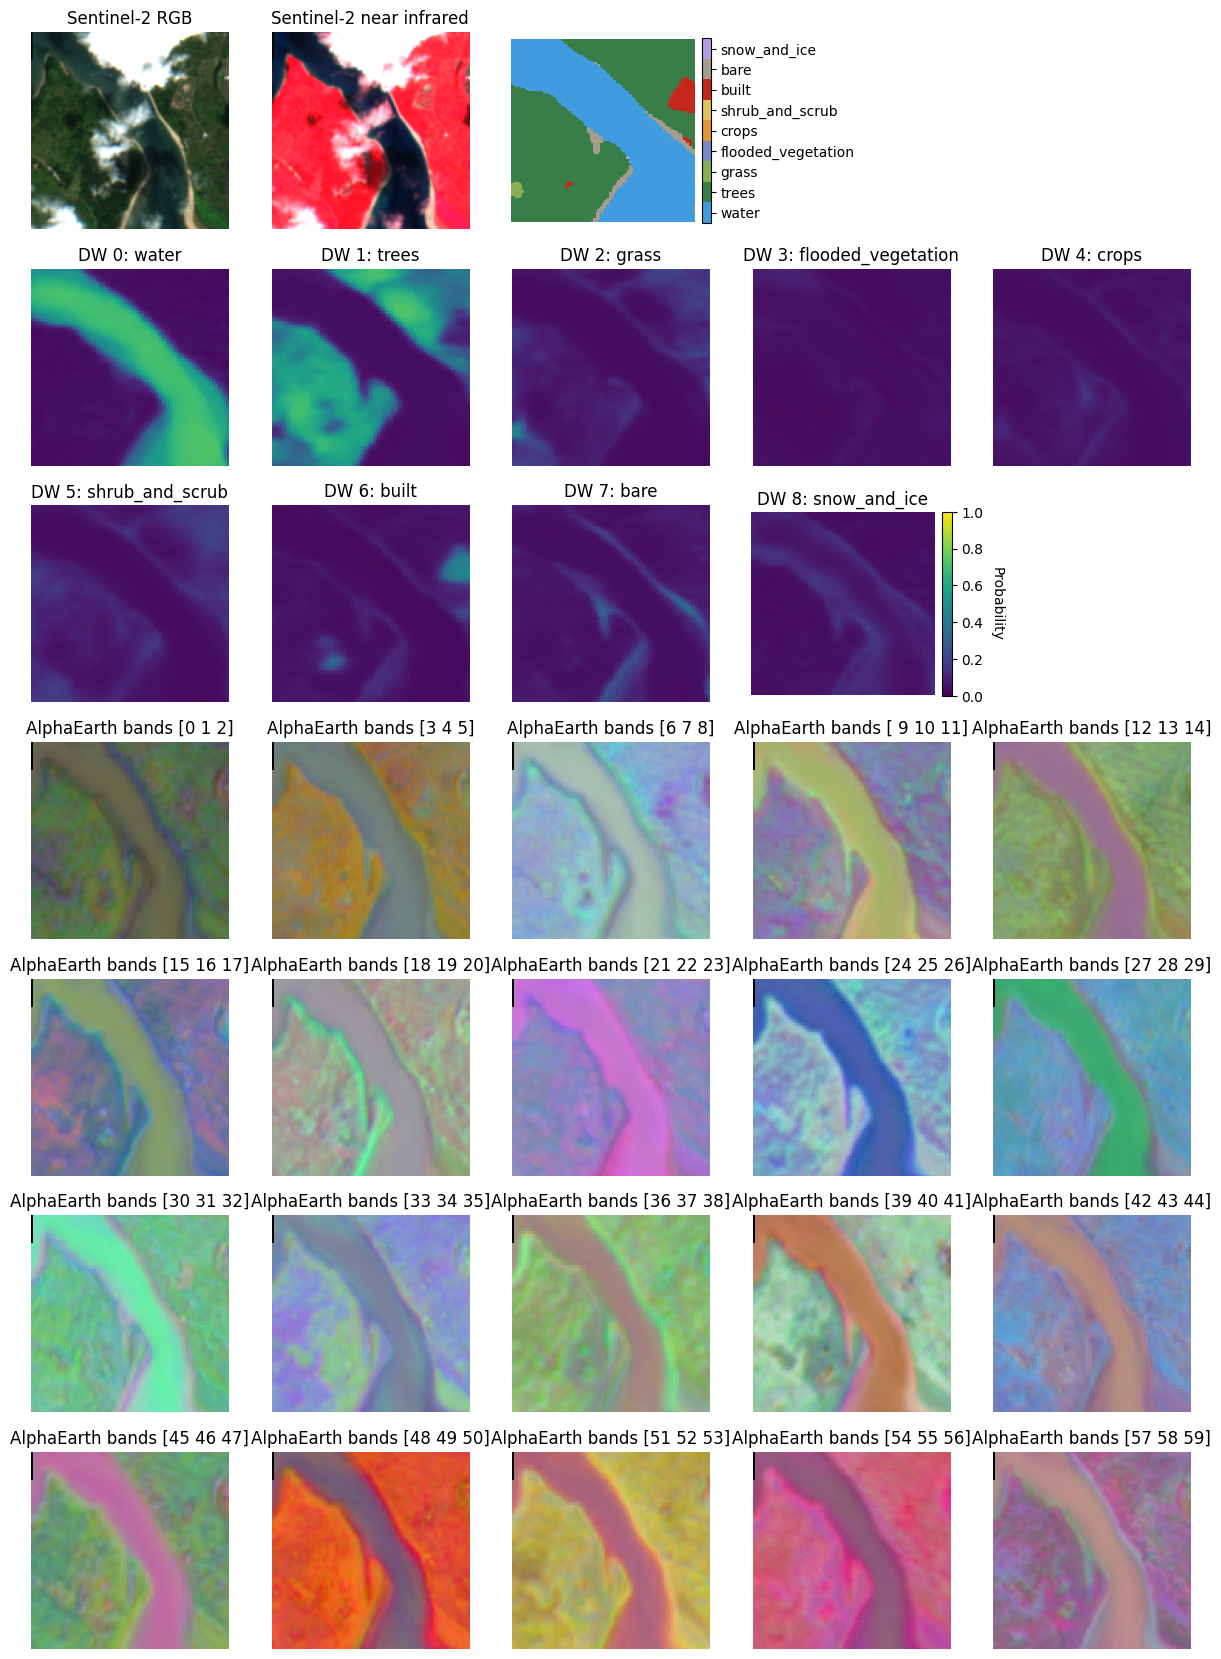

In [3]:

# Get one example dataset and plot
(data_sent, data_alpha, data_dyn, data_worldclim) = du.load_all_modalities_from_name(name='pecl-fig-0', path_folder='../content/sample_data', verbose=1)
du.plot_overview_images('../content/sample_data', name='pecl-fig-0', plot_alphaearth=True, plot_dynamicworld_full=True)


In [168]:

# Then collect from all patches the alpha and dyn data
patches = 10
hypotheses = []
features = []
sentinel = []
for p in range(patches):
    (data_sent, data_alpha, data_dyn, data_worldclim) = du.load_all_modalities_from_name(name=f'pecl-fig-{p}', path_folder='../content/sample_data', verbose=1)
    # Land coverage serves as hypotheses
    hypotheses.append(data_dyn.data)
    # This can definitely be cleaner but I use nan for undefined values
    f_dat = data_alpha.data
    f_dat[~np.isfinite(f_dat)] = np.nan
    f_dat[np.logical_and(f_dat < 0.05, f_dat > -0.05)] = 0  # Thresholding to remove noise
    features.append(f_dat)
    sentinel.append(data_sent.data)

Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray

In [169]:
np.percentile(f_dat, [1, 99])

array([-0.27613995,  0.25990004])

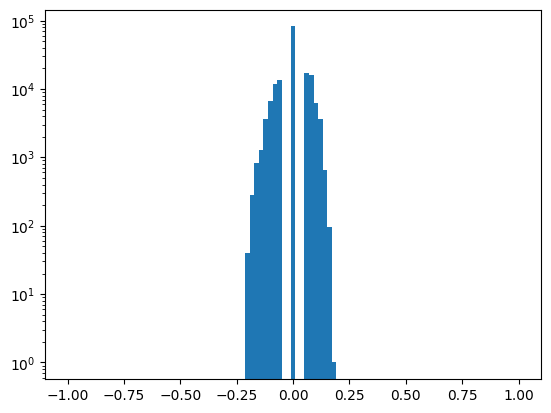

In [170]:
plt.hist(np.swapaxes(np.stack(features), 0, 1).reshape(64, -1)[20, :], bins=np.linspace(-1, 1, 100));
plt.yscale('log')

In [171]:

# Get names of hypotheses: different coarse land coverage classes
names = [k for k in du.create_cmap_dynamic_world().keys()]

In [184]:

# Extract relevant dimensions
radius = 8 # pixels, excluding center pixel (so diameter = 2 * radius + 1)
N_features = features[0].shape[0]
N_pixels = features[0].shape[1]
N_bands = hypotheses[0].shape[0]

In [185]:

# Precalculate for each pixel which values need to be read and written
read = np.zeros([N_pixels, N_pixels, 2, 2], dtype=int)
write = np.zeros([N_pixels, N_pixels, 2, 2], dtype=int)
for row in range(N_pixels):
    for col in range(N_pixels):
        # Choose region of this band to read out
        read[row, col, 0, 0] = max(0, row - radius) # row start
        read[row, col, 0, 1] = min(row + radius + 1, N_pixels) # row stop
        read[row, col, 1, 0] = max(0, col - radius) # col start
        read[row, col, 1, 1] = min(col + radius + 1, N_pixels) # col stop
        # Choose where in the roi to write this to
        write[row, col, 0, 0] = read[row, col, 0, 0] - (row-radius)
        write[row, col, 0, 1] = write[row, col, 0, 0] + (read[row, col, 0, 1] - read[row, col, 0, 0])
        write[row, col, 1, 0] = read[row, col, 1, 0] - (col - radius)
        write[row, col, 1, 1] = write[row, col, 1, 0] + (read[row, col, 1, 1] - read[row, col, 1, 0])


In [186]:
## ROI = 11x11 hypothesis values focussed around focal pixel (per h, per focal pixel)
## STA = 11x11 ROI * 1x1 embed of focal pixel (per embed, per focal pixel) -> averaged across foxal pixels = 11x11 per embed, per h
## patch_stas = (10, (9, 64, 11, 11)) (patch, h, embed, 11x11)
## all_stas = (9, 64, 11, 11) (h, embed, 11x11)


In [187]:

# Run through all patches, collecting spike triggered averages for each feature for each hypothesis
patch_stas = []
for p, (hypothesis, feature) in enumerate(zip(hypotheses, features)):
    print(f'Analysing patch {p+1} / {len(hypotheses)}')
    # Create empty region of interest maps: area around each pixel for each band
    rois = np.full([N_bands, N_pixels, N_pixels, radius * 2 + 1, radius * 2 + 1], np.nan)
    
    # Collect searchlight data for each pixel from all bands of current modality
    for b, band in enumerate(hypothesis):
        print(f'Copying band {b} / {len(hypothesis)}')
        for row in range(N_pixels):
            for col in range(N_pixels):
                # Grab the relevant pixels from the band
                rois[b, row, col, write[row, col, 0, 0]:write[row, col, 0, 1], write[row, col, 1, 0]:write[row, col, 1, 1]] = \
                    band[read[row, col, 0, 0]:read[row, col, 0, 1], read[row, col, 1, 0]:read[row, col, 1, 1]]
                    
    # Collect spike time averages for each band
    stas = []
    for b, band_rois in enumerate(rois):
        print(f'Calculating spike triggered averages for band {b} / {len(rois)}')
        # Then create the spike time average: multiply each roi by the pixel value of the feature pixel
        band_stas = [band_rois * d[:,:,None,None] / np.nansum(np.abs(d)) for d in feature]
        
        # Then average across all pixels and stack to get big output array
        band_stas = np.stack([np.nansum(sta.reshape([-1, radius*2+1, radius*2+1]), axis=0) for sta in band_stas])
        # And append to output stas
        stas.append(band_stas)
    patch_stas.append(np.stack(stas))
# Average across patches to get final stas
all_stas = np.nanmean(np.stack(patch_stas), axis=0)

Analysing patch 1 / 10
Copying band 0 / 9
Copying band 1 / 9
Copying band 2 / 9
Copying band 3 / 9
Copying band 4 / 9
Copying band 5 / 9
Copying band 6 / 9
Copying band 7 / 9
Copying band 8 / 9
Calculating spike triggered averages for band 0 / 9
Calculating spike triggered averages for band 1 / 9
Calculating spike triggered averages for band 2 / 9
Calculating spike triggered averages for band 3 / 9
Calculating spike triggered averages for band 4 / 9
Calculating spike triggered averages for band 5 / 9
Calculating spike triggered averages for band 6 / 9
Calculating spike triggered averages for band 7 / 9
Calculating spike triggered averages for band 8 / 9
Analysing patch 2 / 10
Copying band 0 / 9
Copying band 1 / 9
Copying band 2 / 9
Copying band 3 / 9
Copying band 4 / 9
Copying band 5 / 9
Copying band 6 / 9
Copying band 7 / 9
Copying band 8 / 9
Calculating spike triggered averages for band 0 / 9
Calculating spike triggered averages for band 1 / 9
Calculating spike triggered averages for

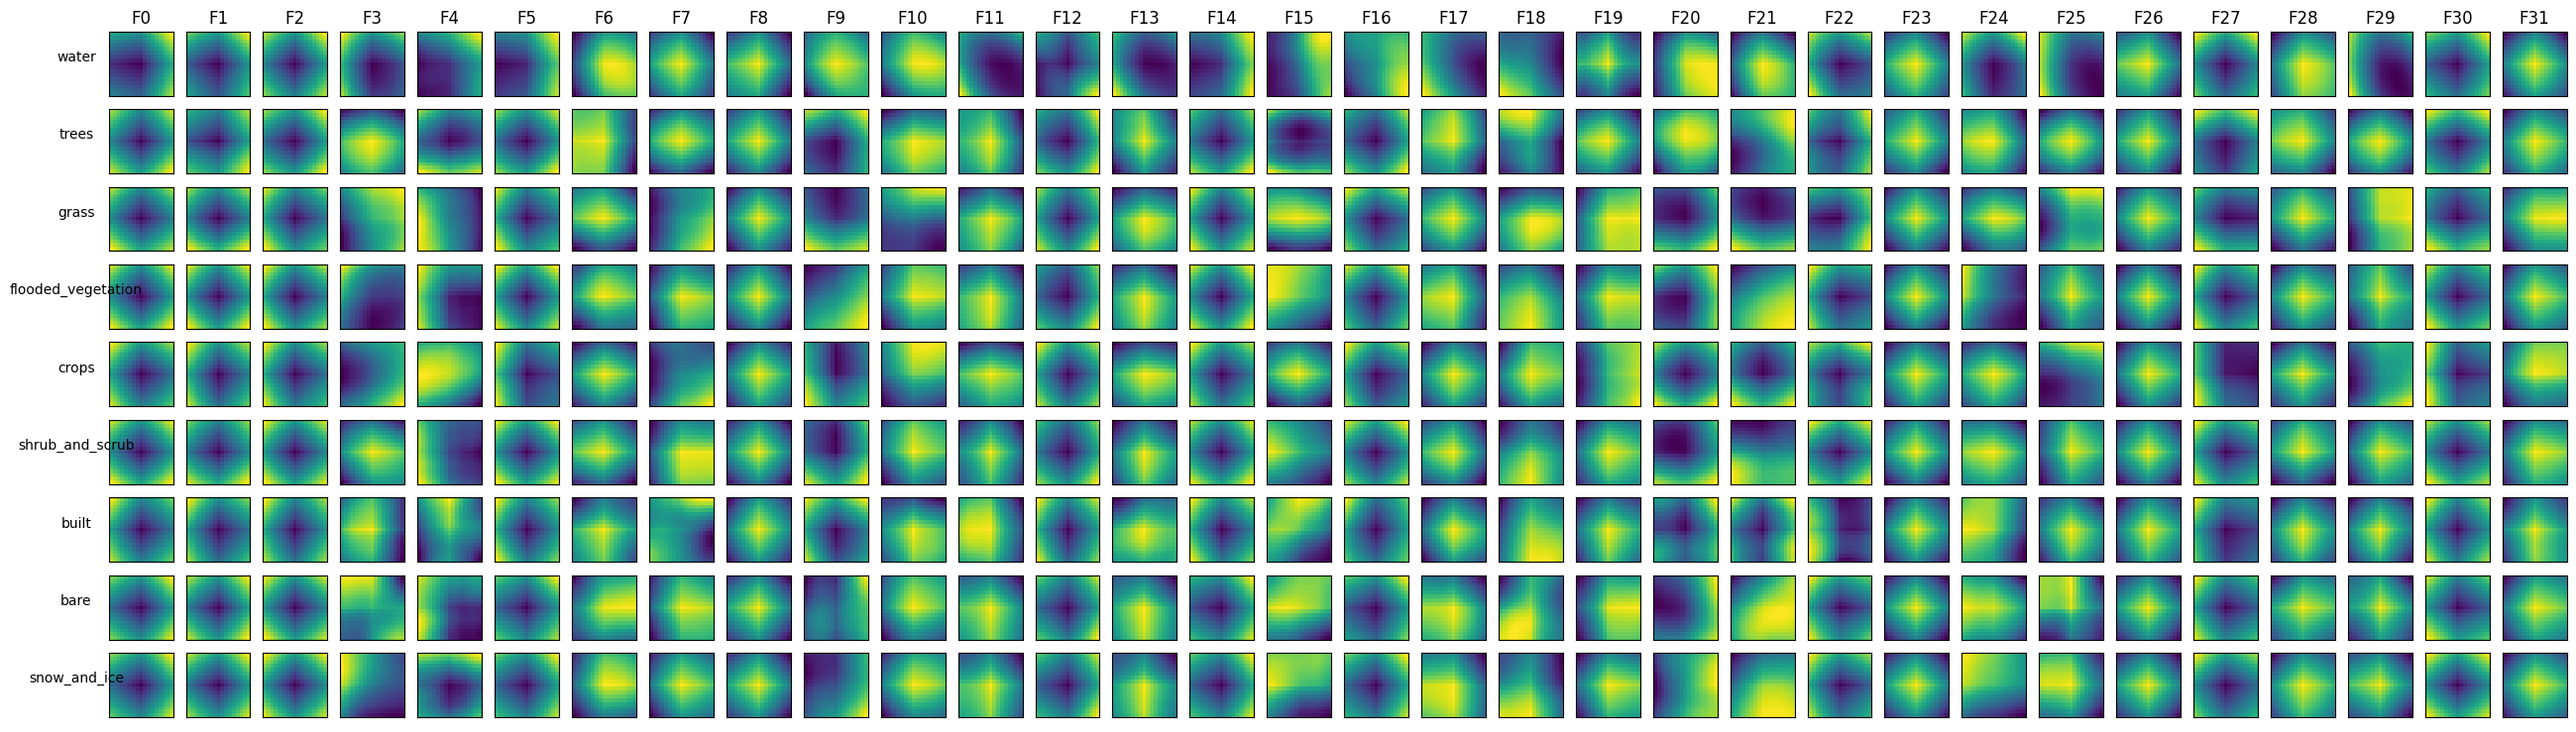

In [192]:
# Plot a selection
b_to_plot = len(all_stas)
f_to_plot = 32
plt.figure(figsize=(f_to_plot, b_to_plot))
lim = np.nanmax(np.abs(all_stas[:b_to_plot, :f_to_plot])) / 2
for row, band_stas in enumerate(all_stas[:b_to_plot]):
    for col, sta in enumerate(band_stas[:f_to_plot]):
        plt.subplot(b_to_plot, f_to_plot, row * f_to_plot + col + 1)
        # plt.imshow(sta, vmin=-lim, vmax=lim, cmap="RdBu_r", interpolation='none') # Minus sign to make blue -> red
        # lim = np.max(np.abs(sta))
        # plt.imshow(sta, cmap='RdBu_r', vmax=lim, vmin=-lim, interpolation='none')
        plt.imshow(sta, cmap='viridis')
        plt.xticks([])
        plt.yticks([])
        if col == 0:
            plt.ylabel(names[row], rotation=0, labelpad=20)
        if row == 0:
            plt.title(f'F{col}')

In [189]:
all_stas.max()

0.3539157798933038

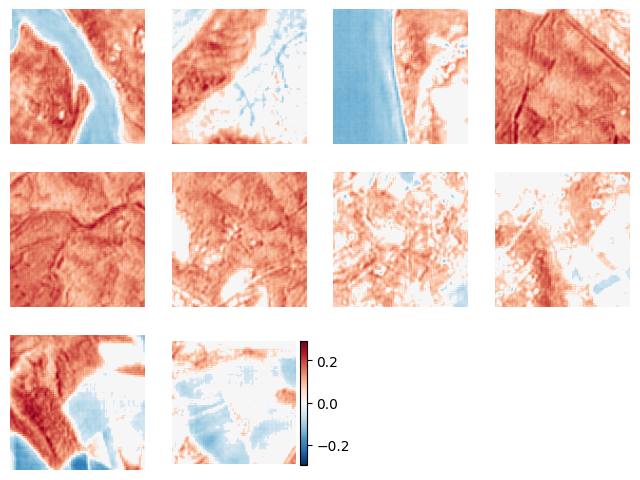

In [195]:
# Plot the map for a particular feature that you might like across patches
curr_f = 29


cols=4
rows=int(np.ceil(patches/cols))
lim = np.nanmax(np.abs(np.stack(features, axis=-1)[curr_f]))

plt.figure(figsize=(2*cols, 2*rows))
for p, feature in enumerate(features):
    plt.subplot(rows, cols, p + 1)
    plt.imshow(feature[curr_f], vmin=-lim, vmax=lim, cmap="RdBu_r")
    plt.axis('off')
    if p == len(features) - 1:
        plt.colorbar(fraction=0.046, pad=0.04)


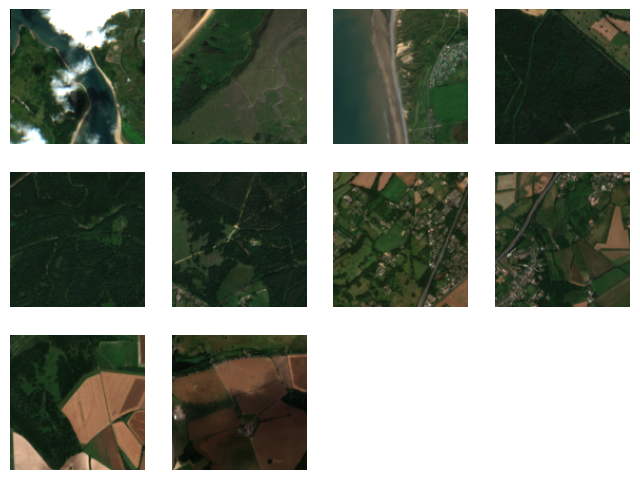

In [191]:

plt.figure(figsize=(2*cols, 2*rows))
for p, sent in enumerate(sentinel):
    plt.subplot(rows, cols, p + 1)
    plt.imshow(np.clip(np.swapaxes(np.swapaxes(sent[:3], 0, 2), 0, 1), 0, 3000) / 3000)
    plt.axis('off')

In [69]:
rows, cols

(3, 4)